In [1]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Circle
from astropy.time import Time

In [2]:
logging.getLogger().setLevel(logging.INFO) # WARNING, INFO or DEBUG
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Import the ScWs from the saved file.

In [4]:
scw_ids = []
scw_versions = []
scw_start_times = []
scw_end_times = []
jupiter_ra = []
jupiter_dec = []

with open("../data/2003-01-01_2025-01-01.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw_ids.append(parts[0])
        scw_versions.append(parts[1])
        scw_start_times.append(float(parts[2]))  
        scw_end_times.append(float(parts[3]))  
        jupiter_ra.append(float(parts[4]))  
        jupiter_dec.append(float(parts[5]))  

unique_sorted_data = {}
for sid, ver, start, end, ra, dec in sorted(zip(scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec), key=lambda x: x[0]):
    if sid not in unique_sorted_data:  
        unique_sorted_data[sid] = (sid, ver, start, end, ra, dec)

scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec = map(list, zip(*unique_sorted_data.values()))

Add IDs and versions together to make correctly formatted ScWs, and compute durations of the ScW observations.

In [5]:
scw_list = [id + "." + ver for id, ver in zip(scw_ids, scw_versions)]
scw_durations = [(end - start)*24*60 for start, end in zip(scw_start_times, scw_end_times)]
print(scw_list)
print(scw_durations)
print([Time(start, format='mjd').isot for start in scw_start_times])
print("Max duration in minutes:", np.max(scw_durations), "at position", np.argmax(scw_durations))

['012001160010.001', '012001170010.001', '012001180010.001', '012301060010.001', '012301070010.001', '012301080010.001', '026601100010.001', '026601110010.001', '026700000210.001', '026700000230.001', '043200640010.001', '043200650010.001', '091700010010.001', '091700020010.001', '106300180010.001', '106300190010.001', '112600220010.001', '112600230010.001', '124200010010.001', '124200020010.001', '168600570010.001', '168600580010.001', '169500010010.001', '169500020010.001', '230200070010.001', '230200080010.001', '230200090010.001', '230200160010.001', '230200170010.001', '230200180010.001', '230200470010.001', '230200480010.001', '230200490010.001', '230200550010.001', '230200560010.001', '230200570010.001', '230200570020.001', '236600410010.001', '236600420010.001', '236600440010.001', '236600450010.001', '236600460010.001', '236600470010.001', '236600480010.001', '236600490010.001', '236600500010.001', '236600510010.001', '236600520010.001', '236600530010.001', '236600540010.001',

We hardcore a catalog for Jupiter.

In [6]:
list_position = 3

# Jupiter
ra_deg = jupiter_ra[list_position]
dec_deg = jupiter_dec[list_position]

api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Jupiter"],
        [125.4826889038086],
        [ra_deg],
        [dec_deg],
        [-32768],
        [2],
        [0],
        [0.0002800000074785203]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "significance",
        "ra",
        "dec",
        "NEW_SOURCE",
        "ISGRI_FLAG",
        "FLAG",
        "ERR_RAD"
    ],
    "cat_column_descr":
        [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["significance", "<f8"],
            ["ra", "<f8"],
            ["dec", "<f8"],
            ["NEW_SOURCE", "<i8"],
            ["ISGRI_FLAG", "<i8"],
            ["FLAG", "<i8"],
            ["ERR_RAD", "<f8"]
        ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}


Query the ODA API.

In [7]:
import json

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

par_dict = {
"RA": ra_deg,
"DEC": dec_deg,
"E1_keV": "15",
"E2_keV": "30", 
"T_format": "mjd",
'T1': scw_start_times[list_position],
'T2': scw_end_times[list_position],
"time_bin": "60", 
"instrument": "isgri",
"osa_version": "OSA11.2",
"product": "isgri_lc",
"product_type": "Real",
"scw_list": [scw_list[list_position]],
'token': oda_api.token.discover_token() ,
'selected_catalog': json.dumps(api_cat)
}

data_collection = disp.get_product(**par_dict)
data_collection.show()

found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
token expires in 214.2 h
discovered token in environment
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
token expires in 214.2 h
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2025-03-16 15:18:36), please wait for https://ww

ID=0 prod_name=isgri_lc_0_Jupiter  meta_data: {'src_name': 'Jupiter', 'time_bin': 0.000694394184392877, 'time': 'TIME', 'rate': 'RATE', 'rate_err': 'ERROR'}



LIGHT CURVE

In [8]:
data_collection.isgri_lc_0_Jupiter.show()

------------------------------
name: isgri_lc
meta_data dict_keys(['src_name', 'time_bin', 'time', 'rate', 'rate_err'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: ISGR-SRC.-LCR


In [9]:
lc=data_collection._p_list[0]
lc.data_unit[1].data

array([(1386.81323132, 74.40108 , 83.35815 , 1.2954814,  1.1226335 , 4.7721524, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81392576, 73.92548 , 52.847572, 1.2964035, -4.6548023 , 4.7758775, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81462019, 74.60025 , 53.64341 , 1.3254974, -2.3899996 , 4.8835053, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81531464, 72.44006 , 51.069664, 1.2794493, -0.16451325, 4.7134213, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81600908, 73.45795 , 52.34818 , 1.3113598, -0.90802616, 4.8315825, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81670351, 75.16615 , 53.713463, 1.29953  , -4.3681974 , 4.7873898, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81739796, 71.5961  , 51.57832 , 1.2789587, -4.312915  , 4.7117133, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81809241, 74.30623 , 54.059277, 1.3050529, -2.0172925 , 4.8081007, 0.99999946, 0.0003472 , 0.00069439),
       (1386.81878685, 74.797356, 52.9035  , 1.3250614, -3.06223

In [10]:
lc.show()

------------------------------
name: isgri_lc
meta_data dict_keys(['src_name', 'time_bin', 'time', 'rate', 'rate_err'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: ISGR-SRC.-LCR


In [11]:
lc.meta_data

{'src_name': 'Jupiter',
 'time_bin': 0.000694394184392877,
 'time': 'TIME',
 'rate': 'RATE',
 'rate_err': 'ERROR'}

In [12]:
lc.data_unit[1].header

{'BACKAPP': True,
 'BANDTYPE': 'ENERGY',
 'BASETYPE': 'DAL_TABLE',
 'BITPIX': 8,
 'BKGPARAM': 'rebinned_back_lcr.fits',
 'CHANTYPE': 'PI',
 'CHECKSUM': 'jWEMjWBMjWBMjWBM',
 'COMMENT': 'STAMP :',
 'CONFIGUR': 'osa_2021-08-27T14:27:00',
 'CREATOR': 'ii_lc_extract 2.7.1',
 'DATASUM': '4204715411',
 'DATE': '2025-03-16T14:19:45',
 'DEADAPP': True,
 'DEADC': 0.777554059521213,
 'DEC_OBJ': 16.2247791290283,
 'DETNAM': 'ISGRI',
 'EQUINOX': 2000.0,
 'EUNIT': 'keV',
 'EXPOSURE': 415.432056103966,
 'EXP_SRC': 112.171111600484,
 'EXTNAME': 'ISGR-SRC.-LCR',
 'EXTREL': '7.9.4',
 'EXTVER': 1,
 'E_MAX': 30.0,
 'E_MIN': 15.0,
 'FITTYPE': 6,
 'GCOUNT': 1,
 'GRPID1': 1,
 'INSTRUME': 'IBIS',
 'ISDCLEVL': 'LCR',
 'MJDREF': 51544.0,
 'NAME': 'Jupiter',
 'NAXIS': 2,
 'NAXIS1': 36,
 'NAXIS2': 10,
 'OBTEND': '00000033226367172608',
 'OBTSTART': '00000033225746415616',
 'OFFCORR': 'rebinned_corr_lcr.fits',
 'ONTIME': 556.649047851562,
 'ORIGIN': 'ISDC',
 'PCOUNT': 0,
 'RADECSYS': 'FK5',
 'RA_OBJ': 140.57899475

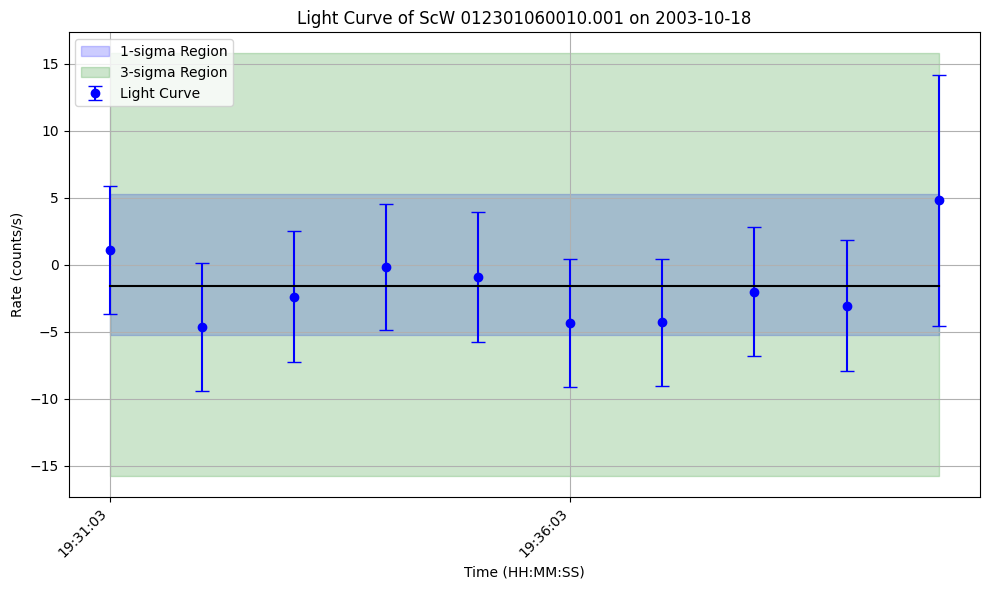

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

time = lc.data_unit[1].data['TIME']
rate = lc.data_unit[1].data['RATE']
error = lc.data_unit[1].data['ERROR'] # just the std of the rate

mjd_ref = lc.data_unit[1].header['MJDREF'] 

time = [Time(mjd_ref + t, format='mjd').isot for t in time]
date_str = time[0].split('T')[0]
time_labels = []
for t in time:
    time_str = t.split('T')[1]
    h, m, s = time_str.split(':')
    s = round(float(s))
    time_labels.append(f'{int(h):02}:{int(m):02}:{s:02}')


plt.figure(figsize=(10, 6))
plt.errorbar(time_labels, rate, yerr=error, label='Light Curve', color='blue',fmt='o', capsize=5)

plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Rate (counts/s)')
plt.title(f'Light Curve of ScW {scw_list[list_position]} on {date_str}')
plt.grid(True)

plt.fill_between(time_labels, -error.mean(), error.mean(), color='blue', alpha=0.2, label='1-sigma Region')
plt.fill_between(time_labels, -3*error.mean(), 3*error.mean(), color='green', alpha=0.2, label='3-sigma Region')

plt.plot([time_labels[0], time_labels[-1]], [np.mean(rate), np.mean(rate)], color='k')

xticks = np.arange(0, len(time_labels), 5) 
plt.xticks(xticks, [time_labels[i] for i in xticks], rotation=45, ha='right')
plt.tight_layout()

plt.legend()

#plt.savefig(f"../data/{scw_list[list_position]}"+"_"+f"LC.pdf", format='pdf', bbox_inches='tight')


In [17]:
np.mean(rate)

-1.2259233

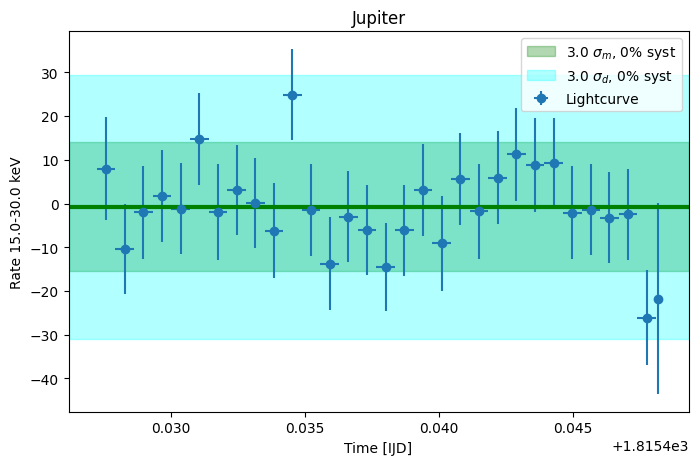

In [19]:
import oda_api.plot_tools
lc = oda_api.plot_tools.OdaLightCurve(data_collection)
lc.show("Jupiter", ng_sig_limit=3.0, find_excesses=True)

In [139]:
lc.write_fits("Jupiter")

('./IBIS_lc_Jupiter.fits',
 53359.403798433224,
 53359.426019513536,
 1269.90130086554)